## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

Found GPU at: /device:GPU:0


# model 1

## Model definition

In [ ]:
imgdir = '/content/gdrive/MyDrive/trams'
img_height = 320
img_width = 240
training_size = 856
validation_size = 214
batch_size = 64

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)

data_gen_valid = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = data_gen.flow_from_directory(
    imgdir + '/model1_final?',  
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'trams'],
    seed=12345,
    shuffle=True,
    subset='training')

validation_generator = data_gen_valid.flow_from_directory(
    imgdir + '/model1_final?',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['other', 'trams'],
    seed=12345,
    shuffle=False,
    subset='validation')

Found 856 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [ ]:
def make_convnet_binary(input_shape=(img_height, img_width, 3)):
  reg = regularizers.l1_l2(l2=1e-3)
  model = Sequential()

  l1 = 16
  model.add(Conv2D(l1, kernel_size=(3,3), padding="same", activation = 'relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

  l2 = 32
  model.add(Conv2D(l2, kernel_size=(3,3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  
  l3 = 64
  model.add(Conv2D(l3, kernel_size=(3,3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  
  l4 = 64
  model.add(Conv2D(l4, kernel_size=(3,3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
  model.add(Flatten())
  model.add(Dense(1280, activation='relu', kernel_regularizer=reg))
  model.add(Dense(1, activation='sigmoid'))
  return model


## Training

In [ ]:
"""
Training with a checkpoint that automatically saved the model with lowest val_loss
"""

checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/trams/best_model.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto')

convnet = make_convnet_binary()
with tf.device('/device:GPU:0'):
  np.random.seed(433334) 
  convnet.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
  np.random.seed(4334)
  history = convnet.fit(
    train_generator, 
    epochs=200, 
    validation_data=validation_generator,
    steps_per_epoch=training_size//batch_size,
    validation_steps=validation_size//batch_size + 1,
    callbacks=[checkpoint])

Epoch 1/200
13/13 [==============================] - 302s 24s/step - loss: 1491.0663 - accuracy: 0.4995 - val_loss: 305.0400 - val_accuracy: 0.5187

Epoch 00001: val_loss improved from inf to 305.04004, saving model to /content/gdrive/MyDrive/trams/best_model.h5
Epoch 2/200
13/13 [==============================] - 22s 1s/step - loss: 264.8676 - accuracy: 0.4960 - val_loss: 149.9935 - val_accuracy: 0.5701

Epoch 00002: val_loss improved from 305.04004 to 149.99352, saving model to /content/gdrive/MyDrive/trams/best_model.h5
Epoch 3/200
13/13 [==============================] - 15s 1s/step - loss: 122.7901 - accuracy: 0.7232 - val_loss: 70.6720 - val_accuracy: 0.7243

Epoch 00003: val_loss improved from 149.99352 to 70.67202, saving model to /content/gdrive/MyDrive/trams/best_model.h5
Epoch 4/200
13/13 [==============================] - 15s 1s/step - loss: 63.3833 - accuracy: 0.7767 - val_loss: 46.2265 - val_accuracy: 0.6355

Epoch 00004: val_loss improved from 70.67202 to 46.22650, savin

## Loading old model

In [ ]:
!ls
import keras
best_model = keras.models.load_model("/content/gdrive/MyDrive/trams/best_model.h5")

best_model.summary()

gdrive	sample_data
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 320, 240, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 120, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 120, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4

## Evaluating model

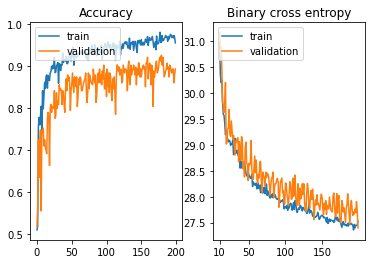

In [ ]:
"""
A function that plots the training history
"""

def get_plots(history):
  fig, axs = plt.subplots(1,2)
  axs[0].plot(history.history['accuracy'])
  axs[0].plot(history.history['val_accuracy'])
  axs[0].legend(['train', 'validation'], loc='upper left')
  axs[0].set_title('Accuracy')

  axs[1].plot(range(10,200), history.history['loss'][10:])
  axs[1].plot(range(10,200), history.history['val_loss'][10:])
  plt.xticks([10, 50, 100, 150])
  axs[1].legend(['train', 'validation'], loc='upper left') 
  axs[1].set_title('Binary cross entropy')
  fig.show()

get_plots(history)

plt.savefig('/content/gdrive/MyDrive/trams/model1_v2_eval.png')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


confusion matix for epoch 20:
[[98  9]
 [14 93]]


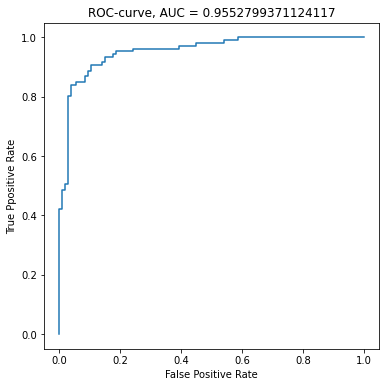

In [ ]:
"""
Gathering some metrics from sklearn
"""

y_true = validation_generator.classes
y_pred = best_model.predict_generator(validation_generator, 4)
y_pred_labels = np.array([1 if pred > 0.5 else 0 for pred in y_pred])

print(metrics.confusion_matrix(y_true, y_pred_labels))

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.title(f'ROC-curve, AUC = {metrics.auc(fpr, tpr)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Ppositive Rate')
plt.savefig('/content/gdrive/MyDrive/trams/model1_v1_roc.png')

## Taking a look at misclassifications

In [ ]:
"""
Here we simply just store the data from the generators in numpy array to make the
data more familiar to work with.
"""

validation_generator.reset()
X_test = np.zeros([validation_size, img_height, img_width, 3])
y_test = np.zeros([validation_size], dtype=int)
for it in range(int(validation_size/batch_size)+1):
  X_batch, y_batch = validation_generator.next()
  X_test[it*batch_size:(it+1)*batch_size, :, :, :] = X_batch
  y_test[it*batch_size:(it+1)*batch_size] = y_batch

In [ ]:
"""
Takes a sample from the validation data and draws the image with it's results as suptitle
"""

def plot_with_label(X, y):
  plt.imshow(X)
  plt.title(f"Tram probability: {round(y[0]*100,2)}%")  
  plt.axis('off')
  plt.tight_layout()
  plt.show()
  print(it)
  #plt.savefig(f'/content/gdrive/MyDrive/trams/model1_missclass{it}.png', bbox_inches = 'tight')


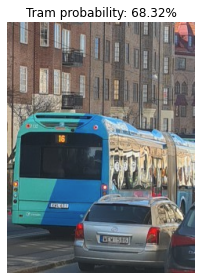

0


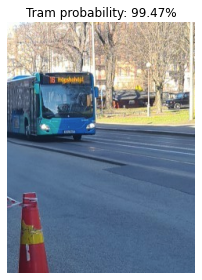

1


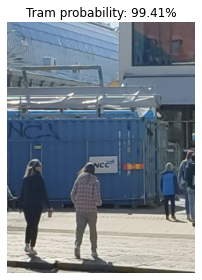

2


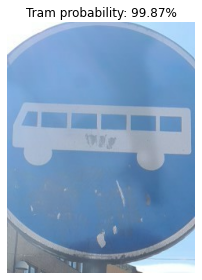

3


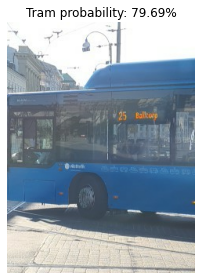

4


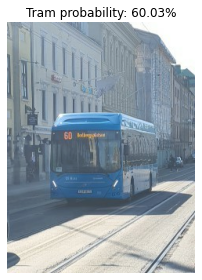

5


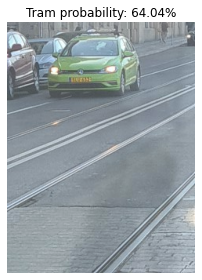

6


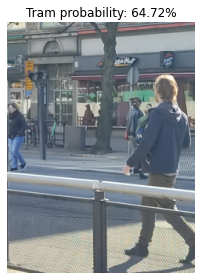

7


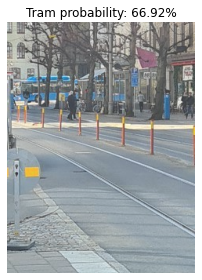

8


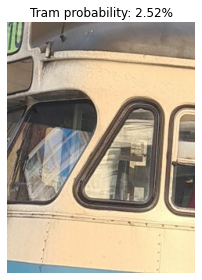

9


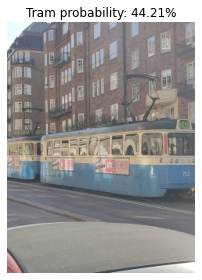

10


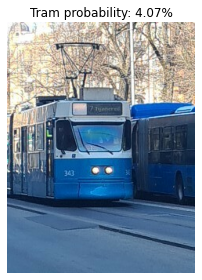

11


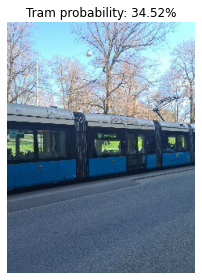

12


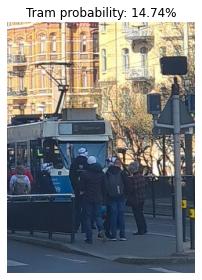

13


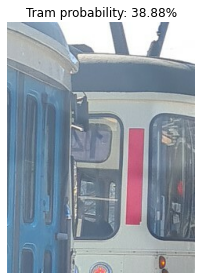

14


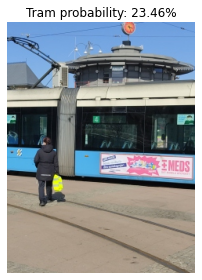

15


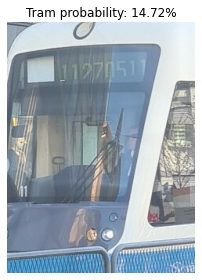

16


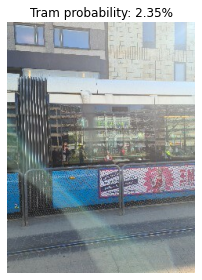

17


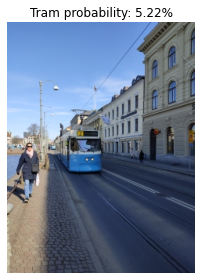

18


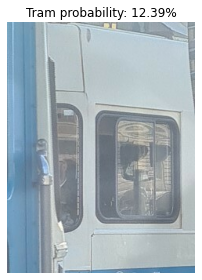

19


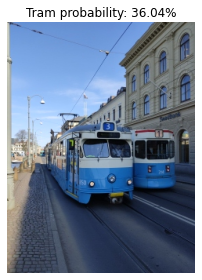

20


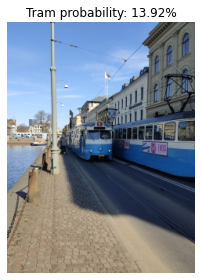

21


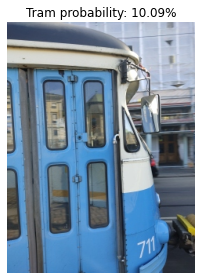

22


In [ ]:
"""
Goes through all the misclassifications and plots them
"""

ind_missclass = np.where(y_pred_labels != y_test)[0]
X_missclass = X_test[ind_missclass]
y_missclass = y_pred_labels[ind_missclass]
for it, ind in enumerate(ind_missclass):
  plot_with_label(X_test[ind], y_pred[ind])
